In [8]:
!pip uninstall arviz
!pip uninstall pymc3

Uninstalling pymc3-3.7:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/pymc3-3.7.dist-info/*
    /usr/local/lib/python3.6/dist-packages/pymc3/*
Proceed (y/n)? y
  Successfully uninstalled pymc3-3.7


In [9]:
!pip install pymc3
!pip install arviz

     |████████████████████████████████| 860kB 9.5MB/s 


     |████████████████████████████████| 1.4MB 9.2MB/s 
     |████████████████████████████████| 4.1MB 46.4MB/s 
     |████████████████████████████████| 307kB 67.7MB/s 


In [0]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc

%config InlineBackend.figure_formats = ['retina']
plt.rc('font', size=12)
plt.style.use('seaborn-darkgrid')

## Bayes Rule
\begin{align}
p(\mu|x) = \frac{p(x|\mu)p(\mu)}{p(x)}
\end{align}
However, it is easier to express in the following form since the denominator is a constant that requires the numerator to integrate to one.
\begin{align}
p(\mu|x) \propto p(x|\mu)p(\mu)
\end{align}

Suppose we have a prior distribution that is (relatively uninformative) on $\mu$ (say normally distributed with a ***standard deviation of 20***). And say that the true distribution was with *a mean of 4* and the _observations_ had a standard deviation of 1. We will see in the following demonstration of how the mean converges to 4 and how the variance decreases.

### The mathemetical way
\begin{align}
p(\mu|x_1,...,x_N) &\propto p(x_1|\mu)p(x_2|\mu)...p(x_N|\mu)p(\mu)\\
&\propto\exp\left(-\frac{1}{2}\left((x_1-\mu)^2+(x_2-\mu)^2+...+(x_N-\mu)^2\right)\right)\exp\left(-\frac{1}{2}\frac{\mu}{20^2}\right)\\
&\propto\exp\left(\mu^2\left(N+\frac{1}{20^2}\right)-2\sum_{i=1}^Nx_i\mu\right)\\
& = \mathcal{N}\left(\frac{\sum x_i}{N+\frac{1}{20^2}},\frac{1}{N+\frac{1}{20^2}}\right)
\end{align}

[ -8.08114038   2.94547196  24.05415891 ... -26.24198508  11.79550804
   9.7245653 ]


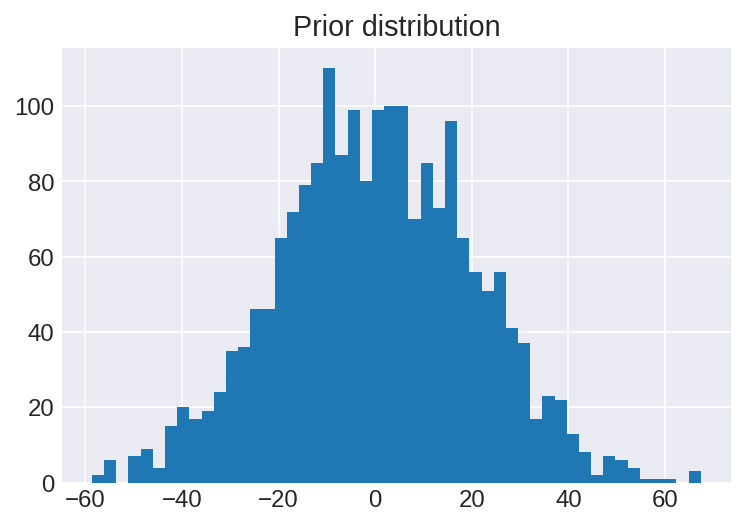

In [3]:
σ_μ = 20
μ = σ_μ * np.random.randn(2000) # prior distribution
print(μ)
plt.hist(μ, 50)
plt.title('Prior distribution')
plt.show()

In [0]:
sum_x = 0
N = 0

data = []
y = 4 + np.random.randn(100,1) #observations
for i in range(100):
    sample = y[i]
    sum_x += sample
    N += 1
    posterior_mean = sum_x/(N+1/σ_μ**2)
    posterior_var = 1/(N+1/σ_μ**2)
    posterior_samples = posterior_mean + np.sqrt(posterior_var) * np.random.randn(2000)
    data.append(posterior_samples)

In [5]:
fig, ax = plt.subplots()
plt.close()
ax.set_xlim(( -4, 8))
ax.set_ylim((-1,250))
line1, = ax.plot([], [], lw=2)
# animation function: this is called sequentially
def animate(i):
    n, bins = np.histogram(data[i], bins=100, range=(-5,5))
  
    line1.set_data(bins[:-1], n)
    return (line1,)
anim = animation.FuncAnimation(fig, animate, frames=100, interval=100, blit=True)
rc('animation', html='jshtml')
anim


## The Probabilistic programming way:
First write down the data model (in this case the data generation process):
\begin{align}
\mu &\sim \mathcal{N}(0, 20) \\
y &\sim \mathcal{N}(\mu, 1)
\end{align}

In [6]:
n_samples = 500

with pm.Model() as model:
    μ = pm.Normal('mu', mu=0, sd=σ_μ)
    likelihood = pm.Normal('y', mu=μ, sd=1, observed=y)
    trace = pm.sample(n_samples, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2015.82draws/s]
The acceptance probability does not match the target. It is 0.8835964487151619, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855821537484662, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9071285910187191, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa3ef51a6a0>,
      dtype=object)

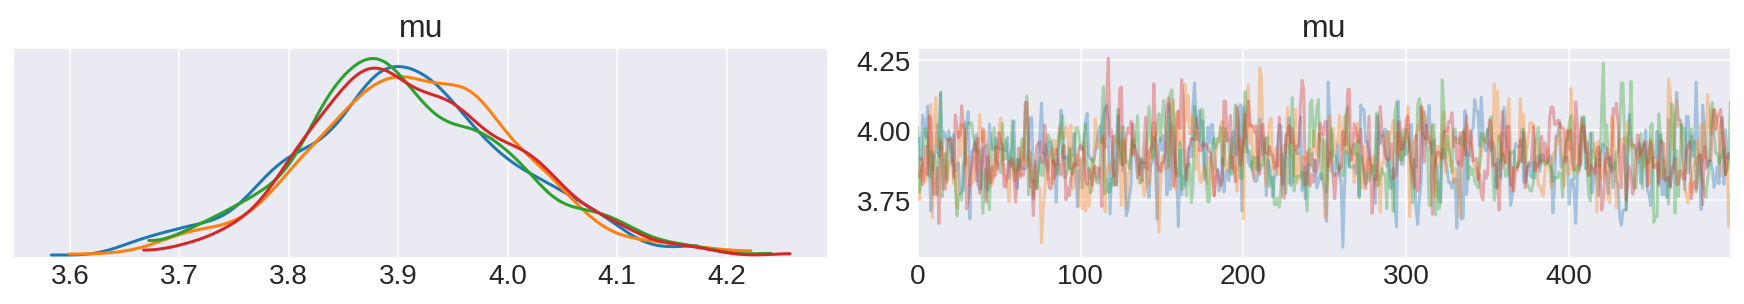

In [7]:
pm.traceplot(trace)

In [9]:
trace['mu'].shape

(2000,)